# Molecular dynamics from scratch

let's start with a pair of atoms interacting with a Lennard Jones potential function.

$E_{LJ} = 4 \epsilon \left[\left( \frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r} \right)^6 \right]$

in one dimension. Where $r$ is $¦r_i - r_j¦$.

The force on the particles is given by
$F = $

In [88]:
import numpy as np
from scipy.constants import Boltzmann
from ase.io.trajectory import Trajectory
import matplotlib.pyplot as plt

In [2]:
r = np.linspace(2.5,10)
epsilon = 0.1 # eV
sigma = 3 # Angstrom

In [3]:
u = 4*epsilon*((sigma/r)**12-(sigma/r)**6)
fr = 4*epsilon*(12*sigma**12*r**(-13)-6*sigma**6*r**(-7))

(-0.1, 0.1)

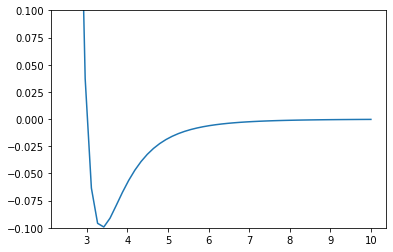

In [4]:
plt.plot(r,u)
plt.ylim(-0.1,0.1)

(-0.2, 0.2)

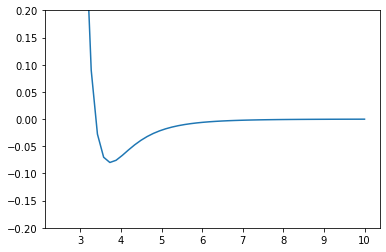

In [5]:
plt.plot(r,fr)
plt.ylim(-0.2,0.2)

### Units
the units of the LJ potential are defined by $\epsilon$ - I'd probably use eV for that. $\sigma$ has dimensions of inverse length and cancels the units of $r$ but I'll use $\unicode{xC5}$.

The kinetic energy is given by $\frac{1}{2}m \mathbf{v.v}$. 

## Model Code

In [6]:
from ase import Atoms
from ase.io.trajectory import Trajectory
import numpy as np

In [7]:
def energyij(model, atomi, atomj):
    """calculates the Lennard Jones potential energy of two particles
    model - model data structure
    atomi - index of atom i
    atomj - index of atom j
    """
    r = np.linalg.norm(model['atoms'][atomi].position - model['atoms'][atomj].position)
    u = 4*epsilon*((sigma/r)**12-(sigma/r)**6)
    return u

def forceij(model, atomi, atomj):
    """calculates the Lennard Jones force between two particles
    model - model data structure
    atomi - index of atom i
    atomj - index of atom j
    returns forces on atom i, fi,  and atom j, fj
    """
    #get magnitude and direction of forces - use Newton's 3rd law for fi = -fj 
    r = np.linalg.norm(model['atoms'][atomi].position - model['atoms'][atomj].position)
    dir = (model['atoms'][atomi].position - model['atoms'][atomj].position)/r
    #calc force magnitude
    fr = -4*epsilon*(12*sigma**12*r**(-13)-6*sigma**6*r**(-7))
    return -fr*dir, fr*dir

#### setup our model - we'll store everything in a dictionary

we'll use the ASE build module to build our initial model

In [8]:
3/(np.sqrt(3)/2)

3.464101615137755

In [69]:
import ase.build as build
# make a conventional face centred cube of Ar atoms 
mycell = build.bulk('Ar', 'fcc', a=4.5, cubic=True)
# make a 2 x 2 x supecell as specified by the P matrix
mysupercell = build.supercells.make_supercell(mycell, P=([[2,0,0],[0,2,0],[0,0,2]]))
#mysupercell = build.supercells.make_supercell(mycell, P=([[4,0,0],[0,4,0],[0,0,4]]))
mysupercell

Atoms(symbols='Ar32', pbc=True, cell=[9.0, 9.0, 9.0])

now to setup the parameters

In [70]:
nsteps = 3000
dt = 0.1
mass = 1.0
d = 4.7
output_freq = 10
#atoms = Atoms('Ar4', positions=[(0.0, 0.0, 0.0),(d,0.0,0), (2*d,0.0,0.0), (3*d,0.0,0.0)])
atoms = mysupercell
#atoms = Atoms('Ar2', positions=[(0.0, 0.0, 0.0),(0.0,0.0,d)])
natoms = len(atoms)

In [71]:
model = dict(natoms = natoms,
             atoms = atoms,
             vel = np.zeros((natoms,3)), 
             forcestp1 = np.zeros((natoms,3)),  
             forcest = np.zeros((natoms,3)),  
             pot_energy = [], 
             KE = [],
             traj = [],
             potential = energyij,
             temp_pos = np.zeros((natoms,3)),
             temp_vel = np.zeros((natoms,3)),
             output_freq = output_freq,
             integrator = 'vverlet'
)
model['atoms']

Atoms(symbols='Ar32', pbc=True, cell=[9.0, 9.0, 9.0])

In [72]:
def integrate(model):
    KE = 0
    if model['integrator'] == 'Euler':
        pot_energy = calcForces(model)
        model['atoms'].positions += model['vel'][:]*dt + 0.5*model['forcestp1'][:]/mass*dt**2
        model['vel'][:] += model['forcestp1'][:]/mass*dt

    elif model['integrator'] == 'vverlet':
        model['forcest'] =  np.copy(model['forcestp1'])
        model['atoms'].positions += model['vel'][:]*dt + 0.5*model['forcest'][:]/mass*dt**2
        pot_energy = calcForces(model)
        model['vel'][:] += 0.5*(model['forcest'][:] + model['forcestp1'][:])/mass*dt            

    else:
        print('no known integrator! falling back on Euler')
        pot_energy = calcForces(model)
        model['atoms'].positions += model['vel'][:]*dt + 0.5*model['forcestp1'][:]/mass*dt**2
        model['vel'][:] += model['forcestp1'][:]/mass*dt
    
    # fancy way of calculating the KE, not sure if it is faster
    #KE = np.sum(np.array([np.dot(model['vel'][i],model['vel'][i]) for i in range(model['natoms'])]))
    
    for i in range(model['natoms']):
        KE += np.dot(model['vel'][i],model['vel'][i])

    return pot_energy, KE

If we have pair potential forces only dependent on the distance, $r_{ij}$ , between a pair of particles we have that
$$
\mathbf{F_i} = \frac{\partial U}{\partial r_{ij}} \cdot \frac{\mathbf{r_{ij}}}{r_{ij}}
$$
and $\mathbf{F_j} = -\mathbf{F_i}$ (Newton's law or due to the change in sign of $\mathbf{r_{ji}}$). 

If we have have multiple particles we should add up all the unique pairs of interactions: 

In [74]:
def calcForces(model):
    energy = 0
    # remember to reset forces at each step
    model['forcestp1'][:] = 0.0
    for atomi in range(model['natoms']):
        #avoid double counting
        for atomj in range(atomi+1, natoms):
            energy += model['potential'](model, atomi, atomj)
            fi, fj = forceij(model,atomi,atomj)
            model['forcestp1'][atomi] += fi
            model['forcestp1'][atomj] += fj
    #print(model['forcestp1'])
    return energy

In [75]:
# actual MD code
#calc energy / forces
calcForces(model)

for step in range(nsteps):

    # integrate
    pot_energy, KE = integrate(model)
    #print(model['forcestp1'])
    
    # save data
    model['pot_energy'].append(pot_energy)
    model['KE'].append(0.5*mass*KE)
    if not step%model['output_freq']:
        print("step {}".format(step))
        # need to copy otherwise we just get a pointer to the latest temp_pos
        model['traj'].append(np.copy(model['atoms'].positions))    

step 0
step 10
step 20
step 30
step 40
step 50
step 60
step 70
step 80
step 90
step 100
step 110
step 120
step 130
step 140
step 150
step 160
step 170
step 180
step 190
step 200
step 210
step 220
step 230
step 240
step 250
step 260
step 270
step 280
step 290
step 300
step 310
step 320
step 330
step 340
step 350
step 360
step 370
step 380
step 390
step 400
step 410
step 420
step 430
step 440
step 450
step 460
step 470
step 480
step 490
step 500
step 510
step 520
step 530
step 540
step 550
step 560
step 570
step 580
step 590
step 600
step 610
step 620
step 630
step 640
step 650
step 660
step 670
step 680
step 690
step 700
step 710
step 720
step 730
step 740
step 750
step 760
step 770
step 780
step 790
step 800
step 810
step 820
step 830
step 840
step 850
step 860
step 870
step 880
step 890
step 900
step 910
step 920
step 930
step 940
step 950
step 960
step 970
step 980
step 990
step 1000
step 1010
step 1020
step 1030
step 1040
step 1050
step 1060
step 1070
step 1080
step 1090
step 1100
s

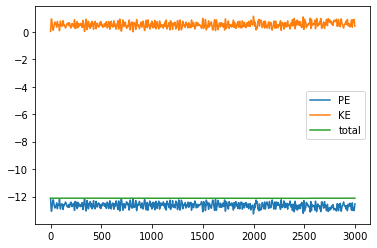

In [76]:
plt.plot(model['pot_energy'], label='PE')
plt.plot(np.array(model['KE']), label='KE')
plt.plot(model['pot_energy'] + np.array(model['KE']), label='total')
plt.legend()

## Visualisation

In [46]:
import nglview as nv

In [77]:
# need to export then reimport at ASE traj ...
# this should go into the dump / output part of the md code
mytraj = Trajectory('mytraj.traj', mode='w')
for traj in model['traj']:
    atoms.positions=traj
    mytraj.write(atoms=atoms)
mytraj.close()
myreadtraj =  Trajectory('mytraj.traj', mode='r')

In [96]:
# viewer - needs ase traj data type
view = nv.show_asetraj(myreadtraj)
view.background = 'white'
view._remote_call("setSize", target="Widget", args=["400px", "400px"])
view

NGLWidget(max_frame=299)

In [95]:
temperature += (mass*(model['vel'][:])^2)/(3*Boltzmann * model['natoms'])
temperature

TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''